***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [5. Imaging](5_0_introduction.ipynb)    
    * Previous: [5.3 Gridding and Degridding for using the FFT](5_3_gridding_and_degridding.ipynb)
    * Next: [5.5 The Break Down of the Small Angle Approximation and the W-Term](5_5_widefield_effect.ipynb)

***

Import standard modules:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import section specific modules:

In [3]:
import matplotlib.image as mpimg
from IPython.display import Image
from ipywidgets import HBox
from astropy.io import fits
import aplpy

#Disable astropy/aplpy logging
import logging
logger0 = logging.getLogger('astropy')
logger0.setLevel(logging.CRITICAL)
logger1 = logging.getLogger('aplpy')
logger1.setLevel(logging.CRITICAL)

/Users/denghui/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [4]:
from IPython.display import HTML, Javascript
HTML('../style/code_toggle.html')

## 5.4 脏图与可见度权重 The Dirty Image and Visibility Weightings <a id='imaging:sec:weights'></a>

到目前为止，我们已经讲了空域滤波器、采样和点扩散函数、以及快速傅立叶变换要用到的网格化，接下来，我们将把这些概念串起来，看看怎么从射电干涉阵的观测数据中得到一张图像。所谓的“脏“图（之所以称之为脏图，是为了跟下一章里的去卷积内容相呼应）可以近似表示为：

Now that we have laid out the concepts of spatial filters, sampling and point spread functions, and gridding for using fast Fourier transforms, we are ready to connect all this topics into one to show how an image is produced from a radio interferomtric array observation. The so called 'dirty' image (the reason for this term relates to the deconvolution stage which is covered in the next chapter) from an observation is approximately

$$ I^{\textrm{D}}(l,m) \approx \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} S(u,v) \, V_{\textrm{obs}}(u,v) \, e^{-2\pi i(ul+vm)} \,du\,dv $$

$V_{\textrm{obs}}(u,v)$表示uv空间的一个完整且连续的观测可见度，这是一个理想量。$S(u,v)$是采样函数，是由基线轨迹构成的uv覆盖。上式是一个近似结果，因为我们在应用[van Cittert-Zernike Theorem &#10142;](../4_Visibility_Space/4_5_The_Fourier_Approximation_VanCittert-Zernike_Theorem.ipynb)时做了降维处理（3-D降到2-D），在下一节里，我们将探讨这种近似处理的局限性，以及如何进行相应的‘w-term’修正。

where $V_{\textrm{obs}}(u,v)$ is the observated visibilities, this function is a complete, continuous measurement of the uv domain, which in reality is never measured because $S(u,v)$ is the sampling function, the main component of which is the uv coverage of the baseline tracks. This is an approximate result as we have used [van Cittert-Zernike Theorem &#10142;](../4_Visibility_Space/4_5_The_Fourier_Approximation_VanCittert-Zernike_Theorem.ipynb) approximation to reduce the complete 3-D visibility equation to 2-D. The limits to this approximation and how to correct for the 'w-term' is covered in the next section.

在前一节的网格化内容里我们已经看到，采样函数$S$里包含uv轨迹采样和网格化算子。在本章后面，采样函数还会被进一步泛化，将包含各种“权重”函数。采样可见度$ V^{\textrm{S}}$表示为：

The sampling function $S$, as we have seen in the previous section on gridding, contains the uv track sampling and the gridding operator. And, as we will see later in this chapter, the sampling function will be generalized to include various 'weighting' functions. It is often useful to talk of the sampled visibilities

$$ V^{\textrm{S}} = S(u,v) \, V_{\textrm{obs}}(u,v) $$

上式把来自所有基线的可见度采样整合到一个可见度空间。从 [5.1 &#10142;](5_1_spatial_frequencies.ipynb)的2-D傅立叶变换已知，脏图是采样可见度的简单傅立叶变换。

which is combination of the visibility samples from all baselines onto a single visibility-space plane. Comparing the dirty image equation to that of the 2-D Fourier transform in Section [5.1 &#10142;](5_1_spatial_frequencies.ipynb) we see that the dirty image is simply the Fourier transform of the sampled visibilities.

$$ I^{\textrm{D}} = \mathscr{F}\{V^{\textrm{S}}\} = \mathscr{F}\{ S V_{\textrm{obs}}\}$$

简洁起见，我们略掉了$(l,m)$ 和 $(u,v)$。根据傅立叶理论([$\S$ 2.5 &#10142;](../2_Mathematical_Groundwork/2_5_convolution.ipynb))，脏图可以理解为两个空域函数的卷积。

The $(l,m)$ and $(u,v)$ notation has been dropped here for compactness. By Fourier theory ([$\S$ 2.5 &#10142;](../2_Mathematical_Groundwork/2_5_convolution.ipynb)) the dirty image can be interpreted as a convolution of two functions. 

$$ I^{\textrm{D}} = \mathscr{F}\{ S \} \circ \mathscr{F}\{ V_{\textrm{obs}}\}$$

上式中的第一个函数$\mathscr{F}\{ S \}$是阵列的PSF响应，跟阵列配置、天空位置、观测时间，以及频率覆盖有关（见[5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb)）。第二个函数$\mathscr{F}\{ V_{\textrm{obs}}\}$是可见度空间的全采样的傅立叶变换。事实上，我们不可能获得$V_{\textrm{obs}}$，但是在下一章[next chapter &#10142;](../6_Deconvolution/6_0_introduction.ipynb)我们将看到，通过预知信息对PSF进行去卷积，我们能得到一个近似的$V_{\textrm{obs}}$。我们可以把$\mathscr{F}\{ V_{\textrm{obs}}\}$看成是在可见度平面上对理想图$I^{\textrm{ideal}}$做的全采样，因此得到下面的脏图公式：

As we have seen in Section [5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb) the first function $\mathscr{F}\{ S \}$ is the PSF response of the array, which we have seen is dependent on the array configuration, sky poisiton, observation time, and frequency coverage. The second function $\mathscr{F}\{ V_{\textrm{obs}}\}$ is the Fourier transform of the fully sampled visibility space. We never has access to $V_{\textrm{obs}}$, but as we will see in the [next chapter &#10142;](../6_Deconvolution/6_0_introduction.ipynb), we include *a priori* information to make an approximate reconstruction of $V_{\textrm{obs}}$ via deconvolution of the PSF. We can think of $\mathscr{F}\{ V_{\textrm{obs}}\}$ being the ideal image $I^{\textrm{ideal}}$ reconstructed from fulling sampling the visibility plane. Re-writing the equation above the dirty image is the convolution of the array PSF with the ideal image.

$$ I^{\textrm{D}} = \textrm{PSF} \circ I^{\textrm{ideal}}$$

回到本章最早的例子，我们采用KAT-7的一次观测的PSF响应[5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb)得到原始鸭子图的脏图。

Returning to examples from earlier in the chapter we can construct a dirty image from the original duck image and the KAT-7 PSF response from one of the observations in Section [5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb).

In [5]:
duck = mpimg.imread('figures/Anas_platyrhynchos_male_female_quadrat_512.png')

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b #standard grayscale conversion
    return gray

gDuck = rgb2gray(duck)
fftDuck = np.fft.fft2(gDuck) #take the Fourier transform of the image to poduce the observed visibilities

In [6]:
hdulist = fits.open('../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_100chans_natural-psf.fits')
psf = hdulist[0].data #shape [polarization, channel, m, l]
sampFunc = np.fft.fft2(psf[0,0]) #take the Fourier transform of the PSF to generate the gridded sampling function

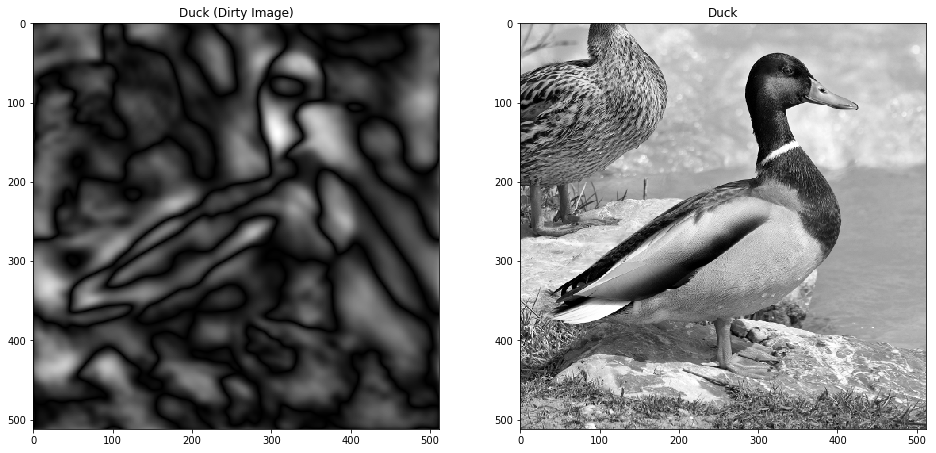

In [7]:
fig, axes = plt.subplots(figsize=(16,8))

ax1 = plt.subplot(1,2,1)
fftDirtyImg = sampFunc * fftDuck #multiplication in Fourier space is equivalent to convolution in image space
dirtyImg = np.abs(np.fft.fftshift(np.fft.ifft2(fftDirtyImg))) #create the dirty image
plt.title('Duck (Dirty Image)')
imgPlot0 = plt.imshow(dirtyImg)
imgPlot0.set_cmap('gray')

ax2 = plt.subplot(1,2,2)
plt.title('Duck')
imgPlot1 = plt.imshow(gDuck)
imgPlot1.set_cmap('gray')

图：鸭子的脏图（左），原始的鸭子图（右），采样函数为KAT-7的100个频率通道，-30度的6小时观测。

*Figure: dirty image of a duck (left) created by sampling the original duck image (right) with a KAT-7 observation using 100 frequency channels, over a 6 hour observation at declination -30 degrees.*

从上面的脏图中很难看出鸭子的形状，但是因为我们已经知道了原始图，所以还能指认出鸭子的头和翅膀。要不是事先知道了原图，还是很难从脏图中看出内容来，这正是干涉测量成像过程中所面临的主要问题，需要不断研究去卷积算法进行解决。

It is hard to make out the duck in the resulting dirty image. The head and long wing can be picked out, but that is likely due to the fact that we know what the original image looked like. Had we not known what the original image was we would have a difficult time deciding what we are seeing. This is the main issue in interferometric imaging, and has perpetuated the development of deconvolution algorithms.

下图是KAT-7的PSF的傅立叶变换，它跟在 [5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb)所看到的uv覆盖图类似。注意色条对应的像素值范围，这体现了uv覆盖的重叠以及权重。为简单起见，到目前为止，我们还没有涉及采样函数跟成图的细节。接下来，我们将在采样函数中进一步引入权重函数。

Plotting the Fourier transform of the PSF should result in a similar image of the uv coverage plot seen in Section [5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb). Indeed it does, but notice that the color bar suggests a range of pixel values. This comes back to the overlapping uv tracks we saw in the uv coverage plots and the type of weighting scheme which was used to produce the PSF. We have been hiding a few details up until this point to simplify the presentation of sampling functions and how they affect resulting images. But, now we will generalize sampling function to introduce weighting functions.

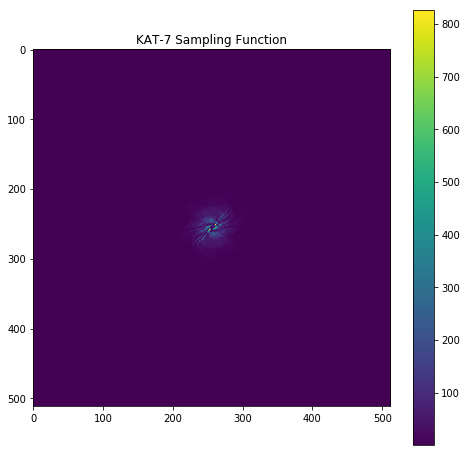

In [8]:
fig = plt.figure(figsize=(8,8))
plt.title('KAT-7 Sampling Function')
imgPlot = plt.imshow(np.abs(np.fft.fftshift(sampFunc)))
plt.colorbar()

图：KAT-7的采样函数，100个通道，-30度6小时观测。

*Figure: KAT-7 sampling function for an observation using 100 frequency channels, over a 6 hour observation at declination -30 degrees.*

### 5.4.1 加权函数以及采样函数的范化 Weighting Functions, a generalization of sampling functions

采样函数（如[5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb)节里的KAT-7的采样函数）由多条基线轨迹构成，因此在可见度域存在空白和重叠的区域。到目前为止，我们所讨论的都是二值化的采样函数，即有采样的位置为1，没有采样的位置为0。之所以把没有采样的位置的值置为0，是因为那些位置有可能为任何值，只是没有被采样到而已。但是，有采样的地方却不一定都为1。例如，假设一次观测有1000个uv采样点，其中100个点测了10次，900个点只测了1次，则这100个点的灵敏度是另外900个点的$\sqrt{10}$倍，因此在成图的时候，由于这100个点的灵敏度更高，应该给予更高的权重。此外，观测阵列可能由多个不同类型的望远镜构成，其中某些基线的灵敏度会高一些，如VLBI，因此在成图的时候，高灵敏度基线的测量结果也应当给予更高的权重。还有些时候，我们需要把点源从大尺度的气体结构中分离出来，因此要重点关注某些特定的空间频率。在上述情况下需要对二值的采样函数进行调整，成图的时候需要考虑更多的因素。事实上，在成图的时候没有标准可循，总是要提前给出权重函数。在成图的时候，最常用到的是密度权重函数，当然，我们也会讨论波束锥化跟可信度权重。

The sampling function, as seen in the Section [5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb) KAT-7 examples, are made up of the various baseline tracks which leads to holes and overlapping sampling of the visibility domain. So far we have discussed sampling functions as if they are binary functions, a visibility domain pixel is given a value of 1 if a baseline track measured that location otherwise the pixel was given a value of 0. The allocation of 0 to each pixel which was not measured should make sense, as there is no information, and thus that pixel can potentially have any value. But, for the measured pixels the sampling function value does not necessarily need to be 1. For example, say an observation results in 1000 uv positions being measured, and 100 of these positions were measured 10 times while the other 900 positions were only measured once. The 100 positions measured 10 times, will have a $\sqrt{10}$ improvement in sensitivity compared to the other 900 positions, so perhaps those 100 spatial frequency modes should be given more weight in the resulting image because we are more sure about the accuracy of the measurement. Or, perhaps an array is made up of many different types of telescopes which leads to some baselines having a higher sensitivity to other baselines, such as in VLBI. Or, perhaps the science case is only interested in certain spatial frequencies, such as seperating point sources from large-scale gas structure. These are all examples of times when we would like to adjust our sampling function, which leads to a number of different options we need to understand when creating an image. In fact, there is no standard set of options to create an image from visibilities, a weighting function must always be decided upon before hand. The most common weighting function we must decide on when imaging is the density weighting function, but we will also discuss the beam taper and reliability weighting.

简单起见，我们在讨论过程中一直把PSF和可见度采样函数看成是一组傅立叶对，然而，确切来讲，PSF和权重函数$W$才是一组傅立叶对，权重函数$W$包含了采样函数。

As a simplification we have been discussing the PSF as being a Fourier pair of the visibility sampling function, but in fact we need to generalize to say that the PSF is a Fourier pair of a weighting function $W$, where $W$ includes the sampling function.

$$ \textrm{PSF}(l,m) \rightleftharpoons W(u,v)$$

把$W$展开，可以看到它由多个函数构成。在本节我们将采用第7讲[<cite data-cite='1999ASPC..180.....T'>Synthesis Imaging in Radio Astronomy II</cite> &#10548;](http://adsabs.harvard.edu/abs/1999ASPC..180.....T)里的符号，并省略了$(u,v)$项。

Expanding $W$ we see that it is made up over a number of functions. For this section we will use the notation based on Lecture 7 of [<cite data-cite='1999ASPC..180.....T'>Synthesis Imaging in Radio Astronomy II</cite> &#10548;](http://adsabs.harvard.edu/abs/1999ASPC..180.....T). For compactness the $(u,v)$ terms have been dropped.

$$ W = R \cdot T \cdot D \cdot S $$

$W$是我们之前已经讨论过的采样函数$S$、强度权重函数$D$、锥化权重函数$T$以及基线依赖的可信度权重函数$R$的乘积。

$W$ is a product of the the sampling function $S$ which we have all ready discussed, a density weight function $D$, an optional taper weight function $T$, and a baseline-dependent reliability weight function $R$.

我们来看一个简单的1-D权重函数及其PSF响应的例子。在这个例子里，如果我们只对中间部分进行采样，则采样函数为矩形，在左图中用蓝色表示。考虑到探测器的响应随着与零点的距离呈线性变化，我们给靠近中心的采样点更大的权重，这就是三角权重函数，在左图中用绿色表示。此外，还可以用高斯权重函数，在左图中用红色表示。这些权重函数的PSF响应各不相同，见右图，蓝色的矩形权重函数的PSF的主瓣最强，然而其旁瓣也明显强于另外两种权重函数。一个函数在空域中平滑，则在傅立叶域里也会平滑，显然，矩形函数不是一个平滑函数。高斯函数是一个平滑函数，但是我们的采样有限，这就意味着必须有截断点。截断高斯的PSF响应（绿色）的主瓣较宽，但旁瓣比矩形函数弱。三角函数跟高斯函数接近。

As a simple example let us look at some 1-D weight functions and the resulting PSFs. For this example lets say we sample the inner centre of a 1-D function. This results in a square or boxcar sampling, as seen in blue in the left-hand figure below. But, say we think some samples are 'better' than others. For example, our detector has a linear response based on the distance from the zero point. Then, we would like to weigh the samples accordingly, giving more weight to samples near the centre and less to the samples on the far edges. This results in a triangle weight function, as seen in green in the left-hand figure below. Or, perhaps a Gaussian weighting function, red in the left-hand figure below, is more appropriate. There are many types of potential weighting functions which all cover the same extent of the sample space. But, these weighting functions result in different PSF responses as seen in the right-hand figure. Using a boxcar weighting function (blue) results in the highest PSF primary lobe, but the sidelobes are significantly higher compared to other weighting functions. This relates to the idea that a smooth function in one domain is also a smooth function in its Fourier domain, and a boxcar function is not a smooth function. A Gaussian function is a smooth function, but the sampling extent (or window in signal processing terms) is finite, this means that there is a cut-off point. The PSF response of a truncated Gaussian (green) has a wider primary lobe but lower sidelobes compared to the boxcar function. As does the triangle function which can as a simple approximation to the Gaussian.

(0, 512)

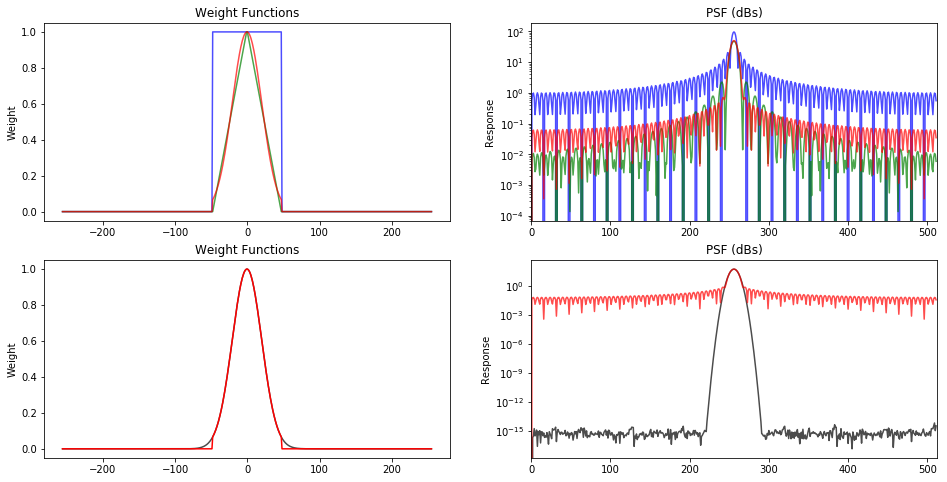

In [9]:
from scipy import signal

whw = 48 #window half width

#Square/Boxcar weight function
squareWeights = np.zeros(512, dtype='float')
squareWeights[256 - whw:256 + whw] = 1.

#Triangle weight function
triWeights = np.zeros(512, dtype='float')
triWeights[256 - whw : 256] = np.linspace(0., 1., num=whw)
triWeights[256 : 256 + whw] = np.linspace(1., 0., num=whw)

#Gaussian weight function
gaussWeights = signal.gaussian(512, std=whw / (2. * np.sqrt(2. * np.log(2.))))
truncGaussWeights = gaussWeights * squareWeights #truncate to window width

xVals = np.arange(-256,256)

fig, axes = plt.subplots(figsize=(16,8))
ax1 = plt.subplot(2,2,1)
plt.title('Weight Functions')
plt.ylabel('Weight')
plt.plot(xVals, squareWeights, 'b-', alpha=0.7)
plt.plot(xVals, triWeights, 'g-', alpha=0.7)
plt.plot(xVals, truncGaussWeights, 'r-', alpha=0.7)
#plt.plot(xVals, gaussWeights, 'k-', alpha=0.7)

ax1 = plt.subplot(2,2,2)
plt.title('PSF (dBs)')
plt.ylabel('Response')
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(squareWeights))), 'b-', alpha=0.7)
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(triWeights))), 'g-', alpha=0.7)
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(truncGaussWeights))), 'r-', alpha=0.7)
#plt.plot(np.abs(np.fft.fftshift(np.fft.fft(gaussWeights))), 'k-', alpha=0.7)
ax1.set_yscale('log')
plt.xlim(0, 512)

ax1 = plt.subplot(2,2,3)
plt.title('Weight Functions')
plt.ylabel('Weight')
plt.plot(xVals, gaussWeights, 'k-', alpha=0.7)
plt.plot(xVals, truncGaussWeights, 'r-', alpha=1.0)

ax1 = plt.subplot(2,2,4)
plt.title('PSF (dBs)')
plt.ylabel('Response')
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(gaussWeights))), 'k-', alpha=0.7)
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(truncGaussWeights))), 'r-', alpha=0.7)
ax1.set_yscale('log')
plt.xlim(0, 512)

*上图：不同类型的1-D权重函数及其PSF响应。蓝色为矩形权重函数，绿色为三角形权重函数，红色为截断高斯权重函数。

*下图：高斯权重和截断高斯权重函数及其PSF响应。黑色为高斯权重函数，红色为截断高斯权重函数，高斯响应中的微弱噪声源于计算精度。

*Top: examples of 1-d weight functions: square (blue), triangle (green), truncated Gaussian (red) and the resulting PSF responses.*

*Bottom: Gaussian (black) and truncated Gaussian (red) weighting function and the resulting PSF responses. The low level 'noise' in the Gaussian response is due to computational accuracy limits.*

上图给出了三种权重函数及其PSF响应，都不完美，各有优劣。矩形函数的PSF的主瓣最强，但旁瓣也强。三角函数的旁瓣最弱，但损失了信号强度跟分辨率（高斯函数也一样）。造成分辨率损失（右图中的主瓣较宽）的原因在于采样函数在中间位置的权重较大，即低空间分辨率模式。

The figure above shows just three possible weighting functions and the resulting PSF responses. There is no 'correct' function, each has advantages and disadvantages. A boxcar function maximizes the PSF primary lobe response but at the expense of high sidelobes. A triangle function minimizes sidelobes but at the expense of some loss in signal, and a loss of resolution (as does the Gaussian). This loss in resolution (that is a wider primary lobe) is because the weight function gives more value to the samples near the centre point, i.e. the lower spatial modes.

后面会看到，在成图的时候，我们会根据不同的需求（是要追求更高的分辨率，还是更高的灵敏度，还是要两者兼顾？）选择合适的采样函数。

As we will see, we can decide on a weighting function when synthesising an image to emphasize for resolution or sensitivity or a combination of the two in the density weighting funciton.

### 5.4.2 密度函数 Density Functions

我们经常在报告、论文中说到的权重函数往往都指的是“密度权重函数”，密度权重函数用于一个uv位置被多次采样，统一权重（uniorm）跟自然权重（natural）是两种常见的密度权重函数。

When discussion of weighting functions (or schemes) comes up in conversations, presentations, or papers it is almost always referring to *density weighting functions*. A density weighting function is used to set the weights of individual uv positions based on the number of times that position is sampled in an observation. One will often see terms such as 'uniform' and 'natural' weighting which are types of density weighting functions.

回到上面提到的KAT-7的采样函数，我们发现采样点的值不是0或者1，而是在一个区间范围内。原因在于由于频率带宽覆盖跟uv轨迹重叠，可见度域里的这些点被多次采样，而在生成PSF响应时，我们给每次采样一个相同的权重，因此采样函数里的这些点的值在一个区间范围内，这跟上面的1-D例子里的高斯权重函数类似。这种权重策略被称为“自然权重”（“natural weighting”，或者“variance weighting”），优点在于灵敏度高，缺点是牺牲了分辨率。文献中经常提到，对低频部分的过度采样导致自然权重的PSF的主瓣的翼（“wings”）变宽。

Going back to the KAT-7 sampling function plot shown earlier, we see that the pixels range in values. That is, during the observation those pixels in the visibility domain were sampled multiple times due to a combination of the frequency bandwidth coverage and the uv track positions. In this case, when we formed the PSF response we decided to give each sample a equal weighting, this resulted in the pixels have a range of weights. This is similar to the Gaussian weighting function in the 1-d example above. This weighting scheme is called *natural weighting* (or inverse variance weighting), it has the advantage of maximizing sensitivity but at the cost of resolution. It is often stated in literature that natural weighting lead to broad 'wings' in the PSF primary lobe, this is due to the over representation of the low spatial frequency modes.

“统一权重”（“uniform weighting” or “unity weighting”）是另一种权重策略，该策略不管采样次数，赋予每个采样点相同的权重。统一权重跟前面1-d采样例子中的矩形采样函数类似，PSF的旁瓣强，但是分辨率较高。

A complimentary weight scheme is *uniform weighting* (or unity weighting) which weights each sample positon equally, not matter how many times that position was sampled. This is akin to the boxcar weighting function in the 1-d example above, and results in a higher resolution image at the cost of higher PSF sidelobes.

在进行网格化（ [gridding section &#10142;](5_3_gridding_and_degridding.ipynb)）时，需要把采样到的可见度赋值到一个2-D的网格像素矩阵。没被采样的像素点的权重为0，一次采样的像素点的权重为1。但是，有些点会被多次采样，有些采样会被分到多个点。在一次采样被分到多个点的情况下，该次采样的总权重为1，然后按一定比例分配给多个点，例如，有两个点$p_a$和$p_b$，如果$p_a$的权重为60%，则$p_b$的权重为40%。如果一个点被多次采样，则该点的权重为采样次数。我们定义一个函数$N_s(u,v)$，其返回值为采样次数，则自然权重表示为：

As covered in the [gridding section &#10142;](5_3_gridding_and_degridding.ipynb), when gridding the sampled visibilities are placed into pixels, that is a 2-D grid array. If no samples are placed in a pixel then that pixel obviously is given zero weight. For a given pixel, if only one sample is placed at that position then it would seem we could justify giving that pixel a weight of one. But, as we have seen, multiple samples, or 'portion' of samples can be placed in a single pixel. If a sample is split between multiple pixels the total allocated weight of the combined positions for that sample should equal one, e.g. if a pixel is split between two pixels $(p_a, p_b)$, with 60% of the flux belonging in $p_a$ and 40% in $p_b$ then the sample is given a weight of 0.6 in $p_a$ and 0.4 in $p_b$. For multiple samples, the weight is the sum of the number of samples. Thus, we define a function $N_s(u,v)$ which returns the number of samples for a given pixel $(u,v)$. A natural weighting function is

$$ D_{\textrm{natural}}(u,v) = N_s(u,v)$$

统一权重函数表示为：

and a uniform weighting function is

$$ D_{\textrm{uniform}}(u,v \, | \, t) = 
\begin{cases} 
    \hfill 1    \hfill & : N_s(u,v) > t  \\
    \hfill 0 \hfill & : N_s(u,v) \leq t \\
\end{cases}
$$

这里$t$是一个非负的阈值参数，通常$t=0$。

where $t$ is a non-negative threshold parameter, usually $t = 0$.

具体采用哪种权重取决于科学目标。希望获得更高的分辨率，可以选择以牺牲灵敏度为代价的统一权重，对于暗弱源，则可以采用以牺牲分辨率为代价的自然权重。下图分别展示了同一个天空模型下的自然权重和统一权重所成的脏图。

When to use a specific weighting scheme depends on the scientific aim of the observation. If you are trying to maximize resolution and are willing to lose some sensitivty then you use uniform weighting. And, if you are observing a weak source and are willing to lose some resolution then you use natural weighting. In the figures below a dirty image is show for natural and uniform weighting based on the same sky.

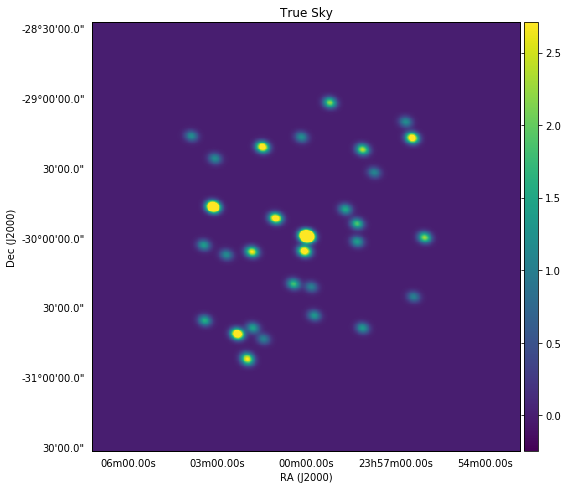

In [10]:
fig = plt.figure(figsize=(8, 8))

gc1 = aplpy.FITSFigure('../data/fits/true/KAT-7_6h60s_dec-30_10MHz_10chans_true.fits', figure=fig)
gc1.show_colorscale(cmap='viridis')
#gc1.show_colorscale(vmin=-2.5, vmax=5., cmap='viridis')
#gc1.hide_axis_labels()
#gc1.hide_tick_labels()
plt.title('True Sky')
gc1.add_colorbar()

fig.canvas.draw()

图：模拟天图，其中的每个源都由一个2-D高斯卷积点源而成，真实的天空是由点源构成的。

*Figure: map of the simulated sky, each source has been convolved with a 2-D Gaussian in this figure but the real sky is made up of point sources.*

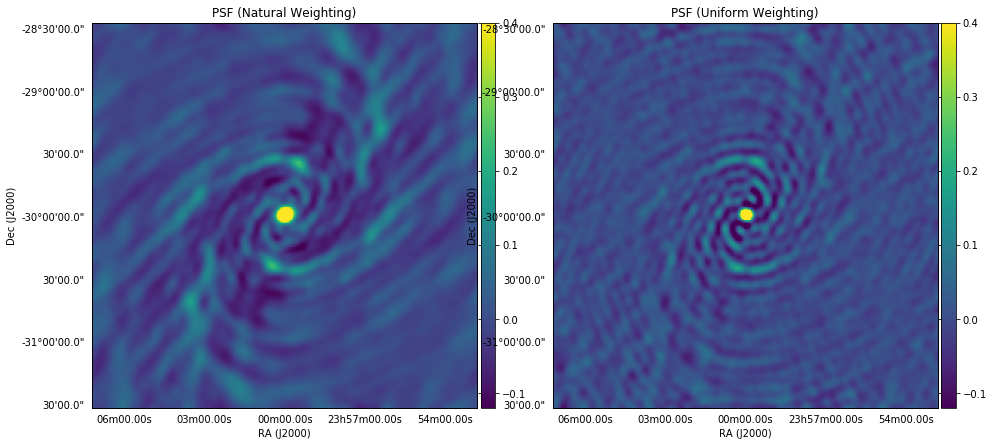

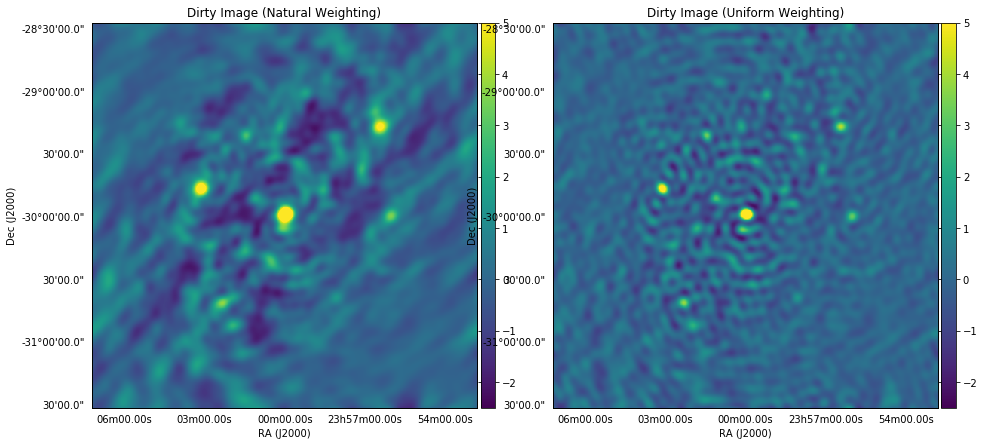

In [11]:
fig = plt.figure(figsize=(16, 7))

gc1 = aplpy.FITSFigure('../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_natural-psf.fits', figure=fig, \
                       subplot=[0.1,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-0.12, vmax=0.4, cmap='viridis')
#gc1.hide_axis_labels()
#gc1.hide_tick_labels()
plt.title('PSF (Natural Weighting)')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure('../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_uniform-psf.fits', figure=fig, \
                       subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(vmin=-0.12, vmax=0.4, cmap='viridis')
#gc2.hide_axis_labels()
#gc2.hide_tick_labels()
plt.title('PSF (Uniform Weighting)')
gc2.add_colorbar()

fig.canvas.draw()

fig = plt.figure(figsize=(16, 7))

gc1 = aplpy.FITSFigure('../data/fits/dirty/KAT-7_6h60s_dec-30_10MHz_10chans_natural-dirty.fits', figure=fig,
                       subplot=[0.1,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-2.5, vmax=5., cmap='viridis')
#gc1.hide_axis_labels()
#gc1.hide_tick_labels()
plt.title('Dirty Image (Natural Weighting)')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure('../data/fits/dirty/KAT-7_6h60s_dec-30_10MHz_10chans_uniform-dirty.fits', figure=fig,
                       subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(-2.5, vmax=5., cmap='viridis')
#gc2.hide_axis_labels()
#gc2.hide_tick_labels()
plt.title('Dirty Image (Uniform Weighting)')
gc2.add_colorbar()

fig.canvas.draw()

上：KAT-7的自然权重PSF（左）和统一权重PSF（右）。

*Top: KAT-7 PSF using natural weighting (left) and uniform weighting (right).*

下：自然权重的脏图（左）和统一权重的脏图（右），其中亮源很清楚，暗源则被PSF的旁瓣噪声掩盖。

*Bottom: dirty image of a simulated field using natural weighting (left) and uniform weighting (right). Only the brighest sources can be seen, many of the weaker sources are hidden in the PSF sidelobe noise.*

跟统一权重相比，自然权重脏图中的源看上去要大一些，原因在于自然权重的PSF响应更大。统一权重里的源的周围有明显的振铃效应，原因在于统一权重PSF的类辛格函数性质，使得其旁瓣不如自然权重的旁瓣平滑。

The source in the naturally-weighted image appear to be larger, due to the larger PSF response, compared to the uniformly-weighted image. The uniformly-weighted image has noticable 'ringing' around sources due to the sinc-like nature of the uniformly-weighted PSF response. This results in more negative PSF sidelobes compared to the smoother naturally-weighted PSF response.

Daniel Briggs 的论文 [<cite data-cite='briggs1995high'>High Fidelity Deconvolution of Moderately Resolved Sources</cite> &#10548;](http://www.aoc.nrao.edu/dissertations/dbriggs/)提出了参数可调的密度权重函数，基本原理为用一个被称为鲁棒性的参数$R$对自然权重和统一权重进行调整，因此被称为鲁棒权重（也被称为Briggs权重）。参数$R$的两端分别为自然权重跟统一权重，零点代表分辨率跟灵敏度处于平衡。不同成图工具对鲁棒权重的具体实现方式会有所不同，但结果应该类似。

The idea of an adjustable parameter-based density weighting function was introduced Daniel Briggs' thesis [<cite data-cite='briggs1995high'>High Fidelity Deconvolution of Moderately Resolved Sources</cite> &#10548;](http://www.aoc.nrao.edu/dissertations/dbriggs/). The fundamental idea presented in this thesis was that natural and uniform weighting were simply two schemes on a continuum of possible weighting schemes controlled by a single parameter called the robustness. For this reason, this generalized weighting scheme is called robust weighting (it is also often called Briggs' weighting). The robustness parameter $R$ was developed such that at its two extreme values robust weighting approximated natural and uniform weighting and the zero point for $R$ represents an equal balance between resolution and image variance. The exact implementation of robust weighting varies between imagers, but all imagers should produce similar results.

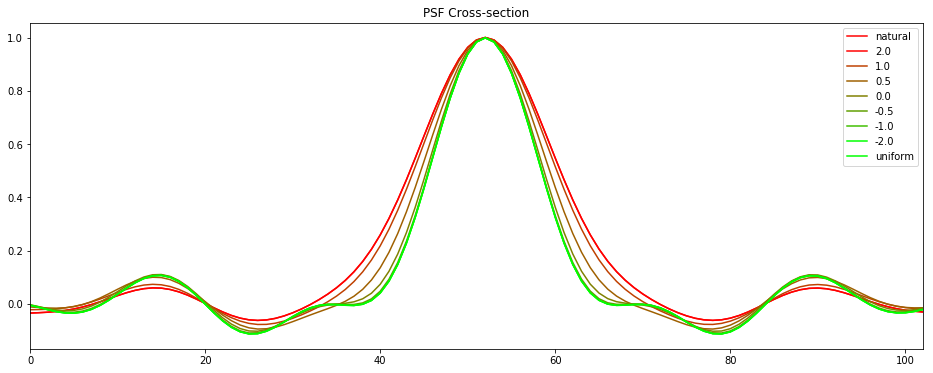

In [12]:
import collections
psfDict = collections.OrderedDict()
psfDict['natural'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_natural-psf.fits'
psfDict['2.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r2.0-psf.fits'
psfDict['1.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r1.0-psf.fits'
psfDict['0.5'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r0.5-psf.fits'
psfDict['0.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r0.0-psf.fits'
psfDict['-0.5'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r-0.5-psf.fits'
psfDict['-1.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r-1.0-psf.fits'
psfDict['-2.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r-2.0-psf.fits'
psfDict['uniform'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_uniform-psf.fits'

fig = plt.figure(figsize=(16, 6))
for key in psfDict:
    fh = fits.open(psfDict[key])
    img = fh[0].data
    psfSlice = img[0,0,int(img.shape[2]/2.)] #take central slice
    subPsfSlice = psfSlice[int(2.*psfSlice.shape[0]/5.):int(3.*psfSlice.shape[0]/5.)] #take inner fifth
    if key=='natural':
        c = [1.0, 0.0, 0.0]
    elif key=='uniform':
        c = [0.0, 1.0, 0.0]
    else:
        norm = (float(key) + 2.)/4.
        c = [norm, 1.0-norm, 0.0]
    plt.plot(subPsfSlice, label=key, color=c)
plt.title('PSF Cross-section')
plt.xlim(0, subPsfSlice.shape[0]-1)
plt.legend()

图：不同权重函数下KAT-7的PSF的横切面。红色为自然权重（natural）、绿色为统一权重（uniform）、棕色为鲁棒权重（robust）。自然权重的旁瓣弱，主瓣宽；统一权重的主瓣窄，旁瓣强；鲁棒权重通过参数调整主瓣和旁瓣。参数为-2时，鲁棒权重接近统一权重，参数为2时鲁棒权重接近自然权重。

*Figure: Cross-section of the KAT-7 PSF for natural, uniform, and a range of robust weighting functions. Natural weighting (red) results in the smallest absolute amplitude sidelobes but at the price of a wider main lobe. Uniform weighting (green) results in the narrowest main lobe but the cost of larges sidelobes. Robust weighting allows for parameterized control to make a trade off between main lobe resolution and sidelobe levels. Robustness of -2 is approximately the same as uniform weighting, and a robustness of 2 is approximately the same at natural weighting.*

采样多的可见度被赋予更高的权重，即自然权重，其鲁棒参数为正，反之，负的鲁棒参数所对应的权重函数接近统一权重。

A weighting function is robust if visibility samples which are oversampled during an observation are favoured over the less well-sampled visibilities, i.e. a natural weighting. Thus, a positive robustness parameter results in a weighting similar to the natural weighting, and a negative robustness results in a weighting similar to uniform weighting.

当鲁棒参数$R = -2$时，鲁棒权重接近统一权重；当$R = 2$，鲁棒权重接近自然权重。鲁棒权重参数的绝对值$|R|$可以大于2。当$R > 2$时，采样较多的短基线的可见度的权重更大，因此图像的分辨率较低，旁瓣较平滑，当我们需要对大尺度弥散结构进行研究时，可以让鲁棒参数$R > 2$。当$R < -2$时，较少采样的长基线的可见度的权重更大，因此图像分辨率较高，旁瓣较强，当我们要研究高信噪比的源，需要更高分辨率的时候，可以设置成这样的参数。 

A robust weighting with $R = -2$ results in an approximately uniform weighting, and $R = 2$ results in an approximately natural weighting. The robust weighting formalization also allows for $|R| > 2$. An $R > 2$ overweights the most oversampled visibility (from the shorter baselines), this will result in lower resolution than natural weighting and smoother sidelobe characteristics, this may be useful when one is interested in imaging large, diffuse structure. An $R < -2$ will up-weight the least sampled visibilities (longest baselines) which results in a a higher resolution image than uniform weighting but also with higher sidelobe characteristics. This may be useful if one is imaging a field which has high signal to noise sources and wish to better resolve those sources.

在基线分布相对均匀的情况下（如KAT-7），密度权重函数的选择还不太重要。然而，对于中央天线多的阵列（如MeerKAT-1和SKA-MID），密度权重函数的选择就变得非常重要。MeerKAT和SKA-MID的很多基线都落在低频区域，如果选择自然权重，则在源的周围会产生类似光晕的结构，而统一权重则会显著提高图像的角分辨率。

In the case where baselines are relatively evenly spread out (such as the KAT-7 example above) the choise of density weighting function is not too important. However, when imaging on core-dense arrays such as MeerKAT array release 1, and in the future SKA MID, it plays an important role. In both these cases a large portion of the baselines falls in the low spatial frequency region, thereby effectively over-emphasising measurements taken in that region. You can see the effect this has on the PSF. In these instances choosing natural weighting will create a halo-like structure around sources, whereas uniform weighting will significantly increase angular resolution.

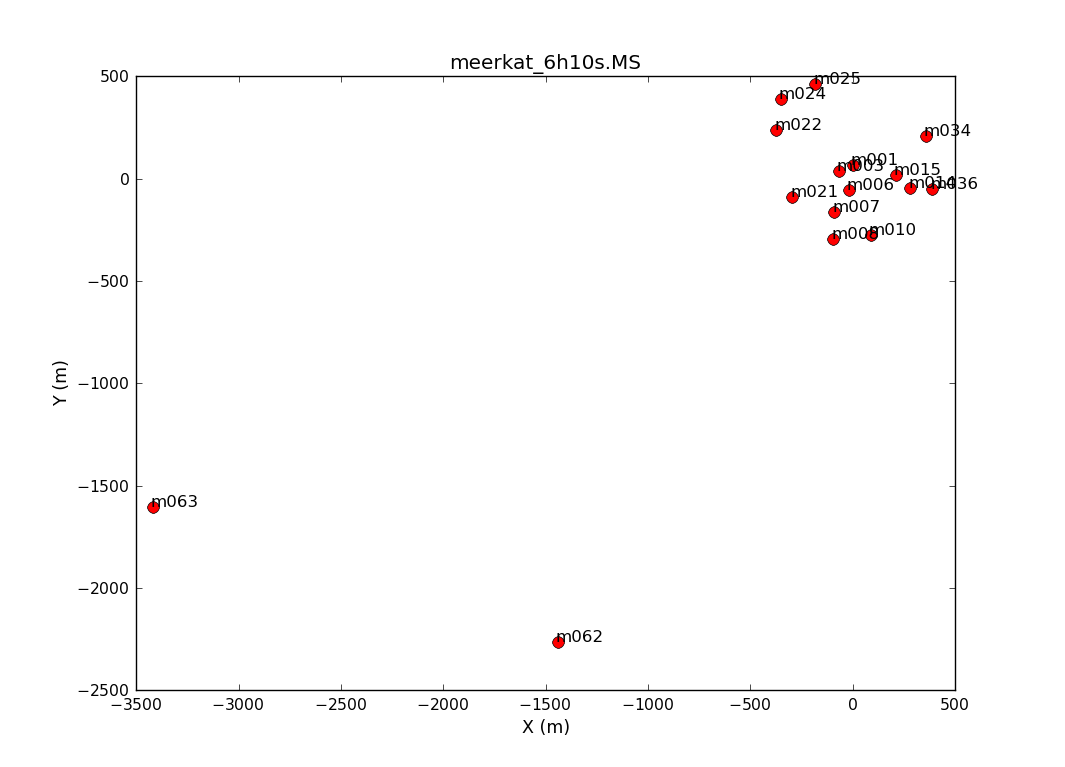

In [13]:
Image(filename="figures/meerkat_AR1.png")

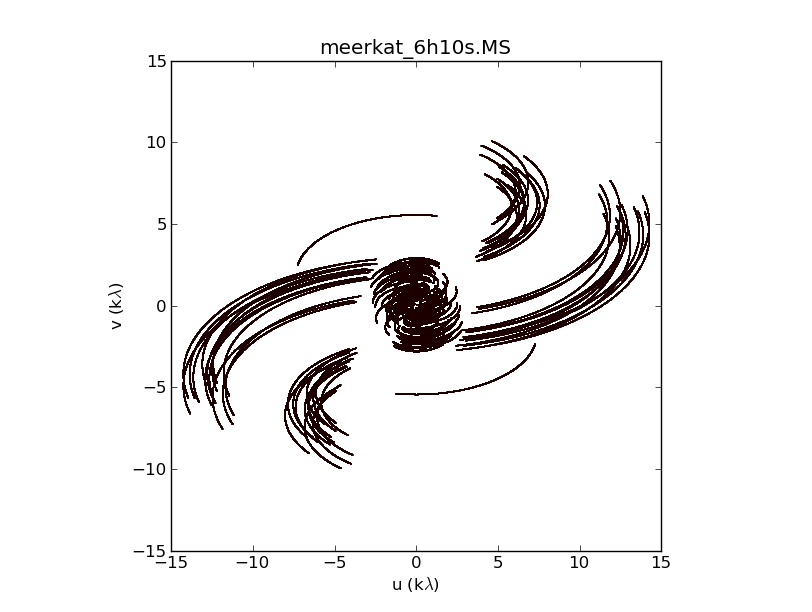

In [18]:
Image(filename="figures/meerkat_16hr_1.1ghz.png")

图：MeerKAT-1的天线布局及其在1.1GHz的6小时UV覆盖。跟JVLA和KAT-7相比，MeerKAT-1的中央区域的基线比较密集。

*Figure: Antenna positions of MeerKAT array release 1 and its associated UV coverage at 1.1GHz for a 6 hour observation. This configuration is especially core dense compared to, for example, the JVLA and KAT-7*

In [14]:
import collections
psfDict = collections.OrderedDict()
psfDict['2.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs2.0-psf.fits'
psfDict['1.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs1.0-psf.fits'
psfDict['0.5'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs0.5-psf.fits'
psfDict['0.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs0-psf.fits'
psfDict['-0.5'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs-0.5-psf.fits'
psfDict['-1.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs-1-psf.fits'
psfDict['-2.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs-2-psf.fits'

fig = plt.figure(figsize=(16, 6))
for key in psfDict:
    fh = fits.open(psfDict[key])
    img = fh[0].data
    psfSlice = img[0,0,int(img.shape[2]/2.)] #take central slice
    subPsfSlice = psfSlice[int(2.*psfSlice.shape[0]/5.):int(3.*psfSlice.shape[0]/5.)] #take inner fifth
    norm = (float(key) + 2.)/4.
    c = [norm, 1.0-norm, 0.0]
    plt.plot(subPsfSlice, label=key, color=c)
plt.title('PSF Cross-section')
plt.xlim(0, subPsfSlice.shape[0]-1)
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs2.0-psf.fits'

除了统一权重、自然权重和鲁棒权重以外，还有一些其它的权重策略，如用于东-西阵列的径向权重，以及独立于图像分辨率跟视场的超统一权重（super-uniform）和亚统一权重（sub-uniform）。在成图的时候，每像素的分辨率和像素的数量（即视场）是可调的，这就意味着，像素的比例可以随着参数改变，因此低分辨率图像的每个像素将包括更多的可见度采样，即便采用相同的权重函数，其PSF响应也会有所不同。超统一权重和亚统一权重可以用于设置固定的网格大小，权重与图像分辨率无关，这就使得不同分辨率不同视场的PSF保持一致。

Uniform, natrual, and robust are not the only weighting schemes. There are array specific ones such as radial weighting which is used with east-west arrays. And, there is super- and sub-uniform weighting which are used to break the dependence of the PSF to the image pixel resolution and field of view. When imaging the pixel resolution and and number of pixels (field of view imaged) is adjustable. This means that the scale of the a pixel will change depending on these parameters. Thus, a low resolution image will include more visibility samples per pixel compared to a higher resolution image, and result in a different PSF response even when using the same weighting function. Super- and sub-uniform weighting can be used to set a fixed grid size for the weighting which is independent of the image resolution. This allows for PSF consistancy across different image resolutions and fields of view.

### 5.4.3 锥函数 Taper Functions

锥函数是密度函数的更一般的形式，两者用于不同的场景，因此被视为两种函数。密度函数用于平衡分辨率和灵敏度，而锥函数用于图像域的平滑滤波。干涉阵在空间频率域进行测量，但是我们往往只对其中的某个频率范围感兴趣。如果我们已经知道观测源的大小，希望尽可能地提高该源的信噪比，这时我们可以用锥函数，这跟数字信号处理中的2-D窗函数类似。如果已经知道一个源的响应，那么我们就可以用一个锥函数来提高该源的信噪比。

A more generalized form of the density function is a taper function. These two functions are presented as different functions since they serve different purposes. While the density function is used to balance between resolution and sensitivity, taper functions are used for applying smooth image-domain filters. An interferometric array measures a range of spatial frequency scales, but say we are only interested in measuring a particular range of those scales. Say we know the size scale of a source that is being observed, or that we do not care about resolving a source but rather maximizing the signal to noise of that source. A taper function acts as a 'matched filter' for a specific signal of interested and is the same as 2-D window functions used in digital signal processing. If the response for a source is known then the signal to noise can be maximized by using the same response as a taper function. [Appendix A &#10142;](5_A_matched_filter.ipynb) of this chapter discusses the use of matched filters in aperture synthesis.

尽管任何一个2-D函数都可以用作锥函数，但实际上通常选择平滑函数。因为高斯函数的傅立叶变换依然是一个高斯函数，所以通常把高斯函数用作锥函数，但是尺度会有所变化，因此需要进行换算。其它锥函数可以参考 [Wikipedia:Window Functions &#10548;](https://en.wikipedia.org/wiki/Window_function)。

Though the taper function can be any 2-D function, in practice it is usually chosen to be smooth. Commonly a 2-D Gaussian is used as this allows for a set image-domain scale to be converted to a visibility-domain scale, as the Fourier transform of a Gaussian is also a Gaussian (the amplitude scale factors will be different requiring normalization). See [Wikipedia:Window Functions &#10548;](https://en.wikipedia.org/wiki/Window_function) for details on other taper functions.

可以用图像中的兴趣宽度（能分辨宽度）去设置高斯函数的半高全宽$\theta_{\text{FWHM}}$，即用一个2-D高斯对图像进行卷积：

The scale of interest in an image can be set the full-width half-maximum of a Gaussian $\theta_{\text{FWHM}}$ in radians. That is, we would like to convolve the image with a 2-D Gaussian

$$ \text{Gauss}(l,m\, | \, \sigma_{I}) = e^{\frac{-(l^2 + m^2)}{2\sigma_{I}^2}}$$

$\sigma_{I}$ 是函数的径向标准差（假定是一个径向对称高斯函数），$\theta_{\text{FWHM}} = 2 \sqrt{2 \ln{2}}\sigma_{I}$。这是一个锥函数的响应函数，跟锥函数构成傅立叶对，uv域的高斯锥函数跟响应函数之间通过$\sigma_{uv} = \frac{1}{2\pi\sigma_{I}}$建立联系，其中$\sigma_{uv}$以波长数为单位。高斯锥函数（未归一化）表示为：

where $\sigma_{I}$ is the standard deviation of the function in radians (we are assuming we want a radially symetric Gaussian), and $\theta_{\text{FWHM}} = 2 \sqrt{2 \ln{2}}\sigma_{I}$. This is the taper response function, which is the Fourier pair to the taper function. The uv-domain Gaussian taper function scale can be related to the taper response function with $\sigma_{uv} = \frac{1}{2\pi\sigma_{I}}$ where $\sigma_{uv}$ is in unit number of wavelengths. The resulting (unnormalized) Gaussian taper function is

$$ \text{Gauss}(u,v\, | \, \sigma_{uv}) = e^{\frac{-(u^2 + v^2)}{2\sigma_{uv}^2}} = e^{\frac{-(u^2 + v^2) \pi^2 \theta_{\text{FWHM}}^2}{2 \ln{2}}}$$

Text(0.5,1,'Taper Function (uv domain)')

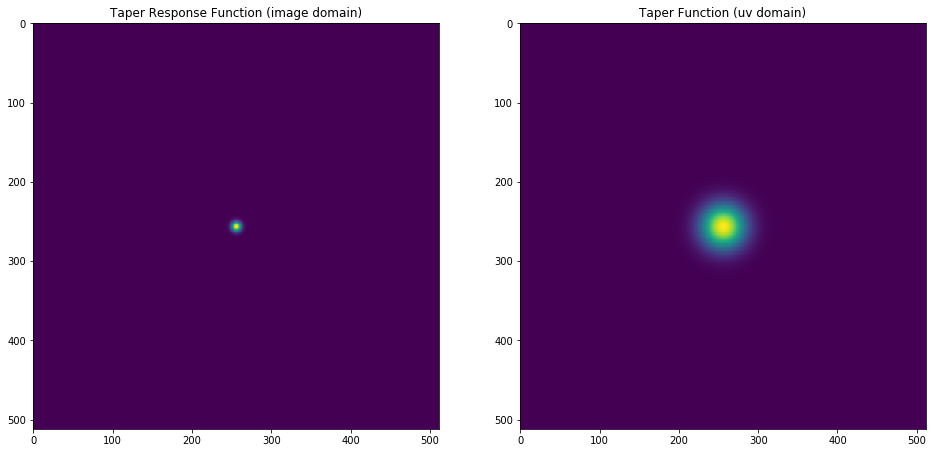

In [20]:
def gaussianTaperResponse(imSize, fwhmTheta):
    #Create an image-domain Gaussian taper response
    #imSize: [int, int] image size
    #fwhmTheta: full-width half-maximum in pixels
    lpos, mpos = np.mgrid[0:imSize[0],0:imSize[1]]
    sigma = fwhmTheta / (2. * np.sqrt(2. * np.log(2)))
    taper = np.exp(-1. * (((lpos - (imSize[0]/2.))**2. + (mpos - (imSize[1]/2.))**2.) / (2. * sigma**2.)))
    return taper

fig = plt.figure(figsize=(16, 8))

plt.subplot(121)
taperResponse = gaussianTaperResponse([512, 512], 10)
plt.imshow(taperResponse, cmap='viridis')
plt.title('Taper Response Function (image domain)')

plt.subplot(122)
taperedFunc = np.abs(np.fft.fftshift(np.fft.fft2(taperResponse)))
plt.imshow(taperedFunc, cmap='viridis')
plt.title('Taper Function (uv domain)')

图：图像域的高斯锥响应函数与uv域的高斯锥函数构成一组傅立叶对。

*Figure: image-domain Gaussian taper response function and the Fourier paired uv-domain taper function.*

高斯锥函数等同于图像处理中的平滑滤波器。同样地，锐化滤波器也可以用作锥函数，用于点源处理。

A Gaussian taper function is equivalent to a smoothing filter used in image processing. Similarly, a sharpen filter could be used as a taper function to filter for compact object such as point sources.

Text(0.5,1,'Dirty Image (40 pixel taper)')

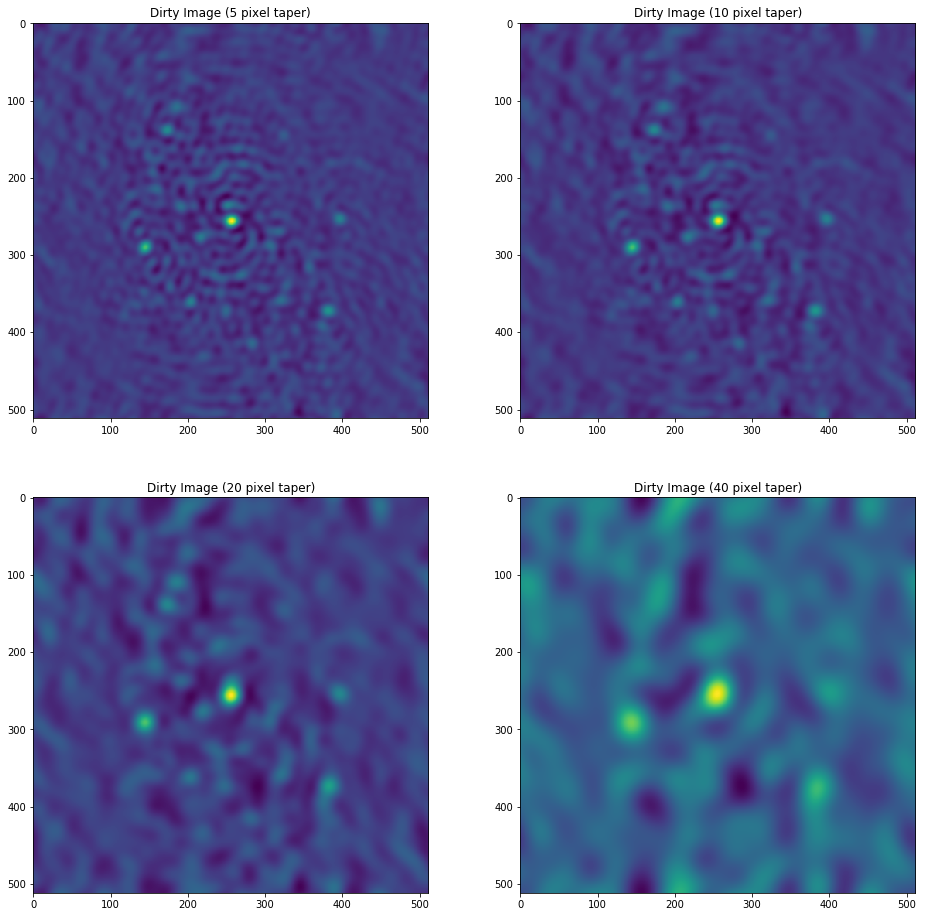

In [21]:
def convolveTaper(taperResponse, img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fft2(taperResponse) * np.fft.fft2(img))).real
    
fh = fits.open('../data/fits/dirty/KAT-7_6h60s_dec-30_10MHz_10chans_uniform-dirty.fits')
img = fh[0].data[0,0]

fig = plt.figure(figsize=(16, 16))

plt.subplot(221)
taperResponse = gaussianTaperResponse(img.shape, 5)
taperedImg = convolveTaper(taperResponse, img)
plt.imshow(taperedImg, cmap='viridis')
plt.title('Dirty Image (5 pixel taper)')

plt.subplot(222)
taperResponse = gaussianTaperResponse(img.shape, 10)
taperedImg = convolveTaper(taperResponse, img)
plt.imshow(taperedImg, cmap='viridis')
plt.title('Dirty Image (10 pixel taper)')

plt.subplot(223)
taperResponse = gaussianTaperResponse(img.shape, 20)
taperedImg = convolveTaper(taperResponse, img)
plt.imshow(taperedImg, cmap='viridis')
plt.title('Dirty Image (20 pixel taper)')

plt.subplot(224)
taperResponse = gaussianTaperResponse(img.shape, 40)
taperedImg = convolveTaper(taperResponse, img)
plt.imshow(taperedImg, cmap='viridis')
plt.title('Dirty Image (40 pixel taper)')

图：对KAT-7的脏图（统一权重）应用不同尺度的锥函数，从左上按顺时针方向的锥宽度分别为：5、10、20、40像素。

*Figure: KAT-7 dirty image (uniform weighting) with different scale tapers applied (from top left clockwise: 5, 10, 20, 40 pixels).*

上图中的原始脏图的分辨率约为5像素，当锥函数的FWHM为5个像素时，卷积后的脏图看不出明显变化（左上图）。但是，随着锥函数的FWHM的增长，脏图的分辨率逐渐变差，原因在于低频部分获得了更高的权重。

In the figures above the the resolution of the original dirty image was approximately 5 pixels, when a 5 pixel Gaussian taper function is applied (top left) there is no noticable effect on the image. But, as the taper size is increased the resolution is reduced as the lower spatial modes are upweighted compared to the higher spatial modes.

一个拥有大量随机分布的天线的干涉阵能获得跟高斯可见度采样分布度接近的采样效果。在统一权重脏图的基础上应用高斯分布的锥函数，将得到跟不带锥函数的自然权重一样的成图效果。

A randomly distributed array with a significant number of elements will result in an well-sampled, approximately Gaussian visibility sampling distribution. Using a uniform weighting with a taper function on the scale of the the Gaussian distribution of the visibilities will produce the same effective image as using natural weighting with no taper function.

### 5.4.4 测量可靠性函数 Measurment Reliability Function

测量可靠性权重函数$R(u,v)$是权重函数的最后一项，该函数跟阵列和观测本身密切相关。如果参与观测的所有组件都一样，则每个可见度测量结果具有相同的可靠性。但是，如果阵列中某个组件的系统温度较高（即噪声较高）或者某个组件的天线接收面积较小（灵敏度较低），则该组件所构成的基线的相关结果的噪声较高，应当在权重上有所体现。一些先验信息，如组件的有效接收面积、系统温度等，也应该体现在可靠性函数里。观测中的一些可变因素，如某个望远镜的放大器的噪声较大需要进行维修，也应该在可靠性函数里有所体现。对于VLBI，可靠性函数必须反映出每个望远镜的灵敏度（因为望远镜的灵敏度各不相同）。如果没有可靠性权重，则把该函数置为1。

The last component of the weighting function is the measurement reliability function $R(u,v)$. This function is intrinsic to an array and observation. If an observation is made with an array of identical elements then the relative reliability of each visibility measurement would be the same. But, say one element of an array has a higher system temperature (i.e. it is noisier) or the element has a smaller dish (less sensitive) then any baseline correlation which includes this element will result in a noisier measurment and should be weighted as such. A priori information, such as an elements effective collection area or expected system temperature, can be included in this function. Variability in the performance of individual elements during an observation is also included in this function. For example, if one of the telescopes has a noisy amplifier which needs to be fixed compared to the other telecsopes in the array. For mixed arrays such as with VLBI each individual telescope will have a different sensitivity which needs to factored in. If no relibabilty weights are included in the original observation then this function is set to unity and ignored.

### 5.4.5 脏图的局限性 Limits of the Dirty Image

从脏图上可以看到在源的周围有一些类似PSF的旁瓣，然而我们知道这只是可见度采样所产生的效果（跟测量仪器自身有关），并不是真实天空。由此我们会问，这些旁瓣能被去掉吗？如果能去掉，我们又会得到什么呢？第二个问题的答案是，如果能去掉较大的旁瓣，我们就能找到隐藏在下面的较暗弱的源，降低图像的噪声水平，或者说，通过去除旁瓣从而提升图像的动态范围。第一个问题的答案是，可以通过去卷积的方法，在一定程度上去掉测量过程所引入的旁瓣结构。

From the dirty images presented earlier in this section we can see that around the sources there are PSF-like sidelobes, but we know that this is an effect of the visibility sampling (our measurement instrument) and not the part of the true sky. So we can then ask, can we remove these sidelobes? And, what is the effect if we can? The answer to the second question is that if we can remove some of the larger sidelobes then we should be able to find other weaker sources in the field that could be hidden below, i.e. the noise floor of the image would be lower. We would say that the dynamic range increases if those sidelobes can be removed. The answer to the first question is that we can remove the structure imposed by the measurement to an extent by the use of deconvolution methods.

综合成像技术发展之初，特别是在引入CLEAN方法去卷积以后，开始使用“脏图”这一术语。CLEAN用于从观测可见度“更好”地复原图像，“更好”是个主观且没有被明确定义的概念，然而，可以确定的是，脏图中的亮源被类似PSF的旁瓣所包围，而这些旁瓣是由不规则采样造成的。假定天空是平滑且连续的，可以推理出可见度也应该平滑且连续。就算只对可见度进行了部分采样，我们也可以基于上述假设，采取适当的方法，增强图像的平滑性，这就得到了被卷积掉PSF的“洁图”。下一章将对此进行详细讨论。

“脏图”一词是在去卷积方法，尤其是CLEAN方法出现以后被引入的。为了获得更好的图像引入了去卷积方法，然后，“更好”是一个比较主观而且缺少明确定义的概念。脏图的主要特点在于亮源周围环绕着一圈类似PSF旁瓣的东西。假定天空应该是平滑且连续的，那么可见度也应该是平滑且连续的，即便我们只对可见度进行了部分采样，依然可以根据这一假定对脏图进行去卷积的平滑处理，从而获得“洁”图。下一章讲详细讨论。

The term 'dirty image' came about after the initial development of synthesis imaging, the term was introduced when deconovlution methods, in particular the CLEAN method, were introduced to recover a 'better' image from the observed visibilities. The concept of better is subjective and not well-defined. But, the main idea is that a dirty image contains bright sources which are surrounded by PSF-like sidelobes due to the irregular visibility sampling. By making the assumption that the sky should be smooth and continuous then we can also assume the visibilities are smooth and continuous. Even though we are only sampling a portion of the visibilities we can use this assumption to enforce a smoothness which results in a 'clean' image in which the PSF has been deconvolved. This will be discussed in detail in the next chapter.

但是，在去卷积之前，我们要先介绍一下大视场成像的内容。在本节开头的地方，我们给出了一个脏图和可见度的方程，但这只是一个近似方程，因为我们忽略了w项，把三维方程简化成了二维。在窄视场的情况下，二维方程尚且可行，但随着视场范围的扩大，w项必须考虑进去。已经有一系列的方法来弥补二维傅立叶的w项问题，我们将在下一节讨论。

But, before we introduce deconvolution we will finish the chapter on the issue of imaging large field of views. At the start of this section we presented an equation which relates the dirty image to the measured visibilities, but this is an approximate equation. The w-term has been ignored to reduce the equation down to a 2-D Fourier transform. This equation holds well for a narrow field of view, but we are often interested in imaging larger fields of view with arrays spread over large areas. In order to do this the w-term must be included. A number of techniques are routinely used to effectively include preturbations to the simple 2-D Fourier relation between visibilities and the image to compensate for the missing w-term. This is that topic that will be covered in the next section.

***

Next: [5.5 The Break Down of the Small Angle Approximation and the W-Term](5_5_widefield_effect.ipynb)